In [1]:
library(arrow)
library(tidyverse)
library(data.table)
library(ggplot2)
library(patchwork)
library(reshape2)
library(gridExtra)
library(parallel)
library(ggpubr)
library(pheatmap)
library(RColorBrewer)
library(viridis)
set.seed(42)

Warning message:
“package ‘arrow’ was built under R version 4.3.3”

Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.

In [2]:
clr_transform <- function(x) {
    if (length(x) == 0) {
        return(NA) # return NA for empty vectors
    }
    geom_mean <- exp(mean(log(x)))
    return(log(x/geom_mean))
}

save_pheatmap <- function(x, filename, width = 12, height = 12) {
    stopifnot(!missing(x))
    stopifnot(!missing(filename))
    if (grepl(".png", filename)) {
        png(filename, width = width, height = height, units = "in", res = 300)
        grid::grid.newpage()
        grid::grid.draw(x$gtable)
        dev.off()
    } else if (grepl(".pdf", filename)) {
        pdf(filename, width = width, height = height)
        grid::grid.newpage()
        grid::grid.draw(x$gtable)
        dev.off()
    } else {
        print("Filename did not contain '.png' or '.pdf'")
    }
}

In [3]:
meta_data <- read.csv("/home//workspace/IHA_Figure_Revision/Dataset/scRNA_meta_data-2024-05-09.csv")

In [4]:
df <- readr::read_csv("04_TCR_Stim_Exp/annotated1.csv")

Rows: 6937027 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): condition, donor, time, group, cell_type, L1, L2, L3, L4, Final_Ce...
dbl (22): FSC, FSC-H, SSC, SSC-B, SSC-B-H, SSC-H, CCR7, IFNg, CD3, CD45RA, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
colnames(df)

[1] "FSC"            "FSC-H"          "SSC"            "SSC-B"         
 [5] "SSC-B-H"        "SSC-H"          "CCR7"           "IFNg"          
 [9] "CD3"            "CD45RA"         "CD27"           "IL4"           
[13] "CXCR5"          "FVS510"         "CD4"            "CD40L"         
[17] "CD8"            "Time"           "condition"      "donor"         
[21] "time"           "group"          "cell_type"      "expt"          
[25] "clustering"     "UMAP_1"         "UMAP_2"         "L1"            
[29] "L2"             "L3"             "L4"             "Final_Celltype"

In [ ]:
freq_df <- df %>%
    group_by(donor, condition, Final_Celltype) %>%
    summarise(count = n(), .groups = "drop") %>%
    group_by(donor, condition) %>%
    mutate(percentage = count/sum(count) * 100, percentage_clr = clr_transform(percentage))

freq_df$cohort <- substr(freq_df$donor, 1, 3)

freq_df <- left_join(freq_df, unique(meta_data[c("subjectGuid", "CMV")]),
                     by = c(donor = "subjectGuid"))

freq_df_subset<-freq_df %>%
    filter(grepl("IL4\\+", Final_Celltype), 
           grepl("IFNg\\-", Final_Celltype),
           grepl("Unstimulated", condition),
           !grepl("Other", Final_Celltype)) %>% ungroup()

In [23]:
write.csv(freq_df_subset %>% select(-CMV),"/home/workspace/Source_Data/Fig5i.csv", row.names=FALSE)

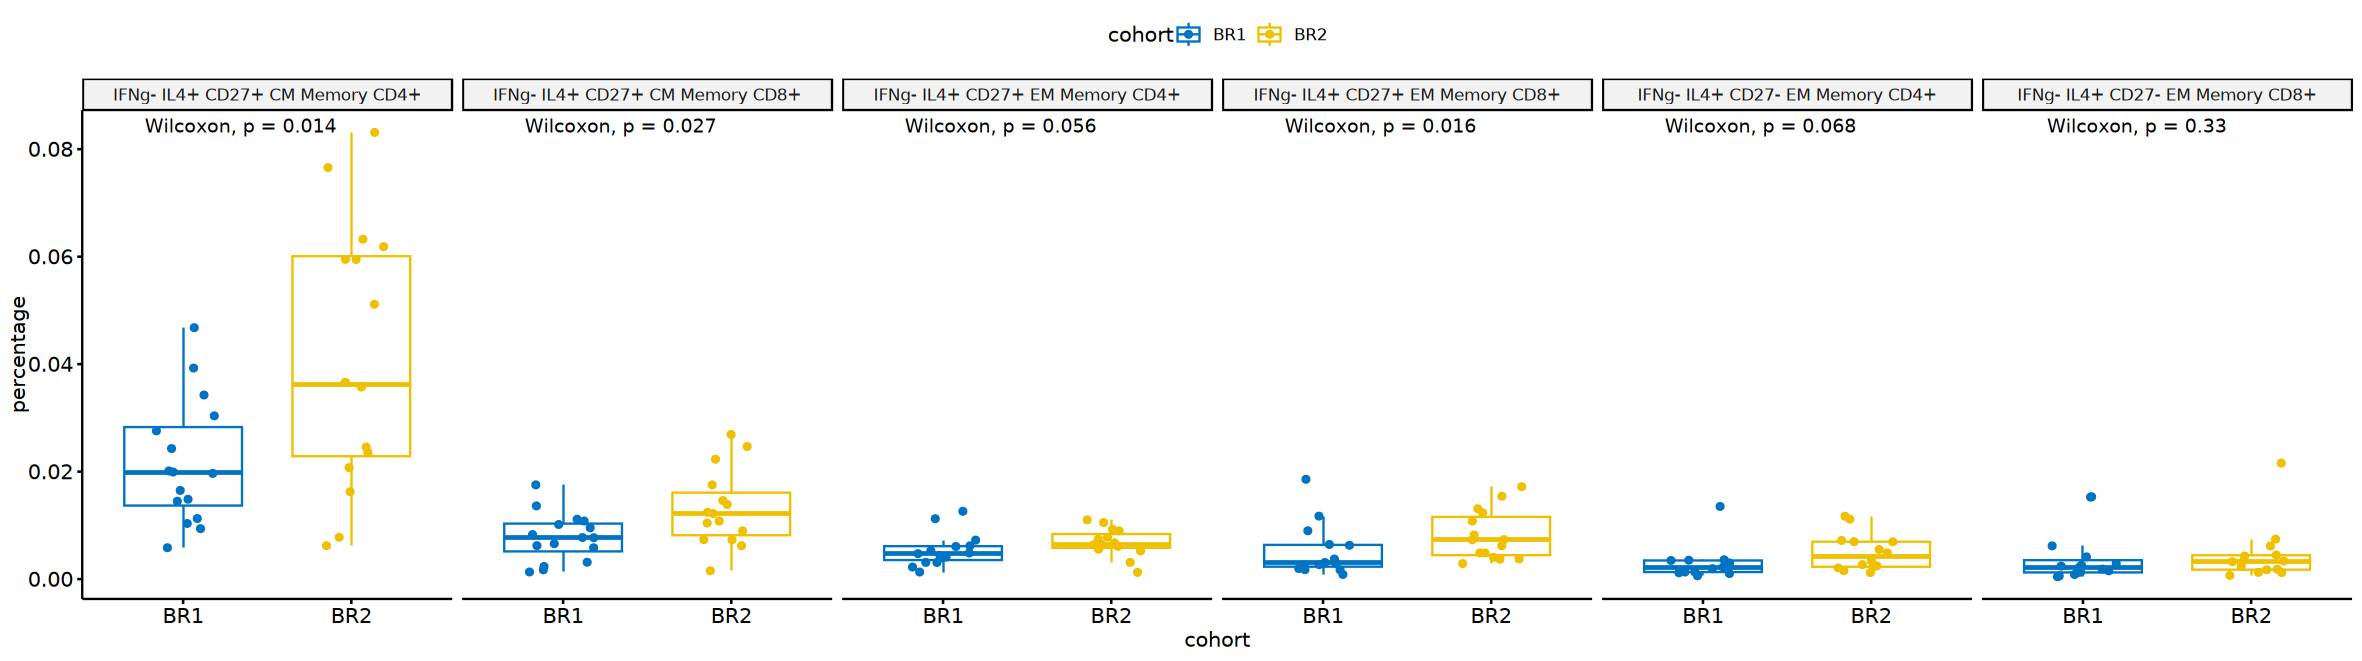

In [22]:
options(repr.plot.width = 500/25.4, repr.plot.height = 140/25.4)

p <- ggboxplot(freq_df_subset, x = "cohort", y = "percentage", color = "cohort", palette = "jco", add = "jitter") + facet_wrap(~Final_Celltype, ncol = 6)

p + stat_compare_means()

In [ ]:
freq_df_subset_wide <- freq_df_subset %>%
    select(Final_Celltype, percentage, donor) %>%
    pivot_wider(names_from = donor, values_from = percentage) %>%
    as.data.frame()

rownames(freq_df_subset_wide) <- freq_df_subset_wide$Final_Celltype
freq_df_subset_wide <- freq_df_subset_wide %>%
    select(-Final_Celltype)

freq_df_subset_wide <- freq_df_subset_wide %>%
    select(where(~ all(!is.na(.))))
# freq_df_subset_wide <- freq_df_subset_wide %>% mutate(across(everything(), ~ replace_na(., 0)))

annotation_df <- as.data.frame(substr(colnames(freq_df_subset_wide), 1, 3))
colnames(annotation_df) <- "cohort.cohortGuid"

In [20]:
# Create the annotation dataframe with only the cohort.cohortGuid

annotation_df <- annotation_df %>%
    mutate(`Age Group` = ifelse(cohort.cohortGuid == "BR1", "Young", "Older")) %>%
    select(`Age Group`)

annotation_colors <- list(`Age Group` = c(Young = "#35978F", Older = "#BF812D"))

In [21]:
breaks_sequence <- seq(-1, 1, length.out = 100)

In [22]:
column_labels <- rownames(freq_df_subset_wide)

In [23]:
rownames(annotation_df) <- colnames(freq_df_subset_wide)

pdf 
  2

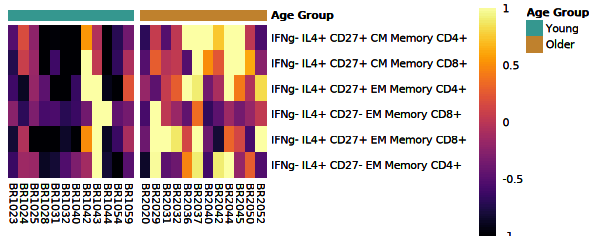

In [25]:
options(repr.plot.width = 130/25.4, repr.plot.height = 50/25.4)
p <- heatmap_plot <- pheatmap(freq_df_subset_wide,
    scale = "row", cluster_cols = FALSE, cluster_rows = FALSE, fontsize = 6, gaps_col = c(12), annotation_col = annotation_df,
    breaks = breaks_sequence, annotation_colors = annotation_colors, border_color = NA, color = inferno(100)
)
p
save_pheatmap(p, "FigureI.pdf", width = 120/25.4, height = 70/25.4)